# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.
9. SGD performed much faster, but not very accurate
9. Interpreted Logistic Model - only 4 variables worth keeping
10. Reduced logistic model performs about the same, but much simpler

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [2]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Read in preprocessed data from previous assignment

In [3]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [66]:
print(cc_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [5]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [6]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [7]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [8]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 10
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [9]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [44]:
def grid_searcher(X, y, model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(X, y)
    return clf

In [45]:
# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, cv_object)

#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.8121
The best parameters of model is:  {'C': 10, 'penalty': 'l1', 'class_weight': None}


# The grid search reveals 
# [Insert something here]
format smaller when complete

### Find coefficients 

In [47]:
def full_classify(X, y, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    acc_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)
        acc_list.append(mt.accuracy_score(y[test_indices],y_hat))

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat))
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list, acc_list

In [49]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled, logit_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.806
confusion matrix
 [[4529  147]
 [1017  307]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4676
          1       0.68      0.23      0.35      1324

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.600217993017


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.814833333333
confusion matrix
 [[4557  132]
 [ 979  332]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4689
          1       0.72      0.25      0.37      1311

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.612545404235


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.811
confusion matrix
 [[4528  139]
 [ 995  338]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4667
          1       0.71      0.25      0.37      1333

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.611889901981


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.811666666667
confusion matrix
 [[4555  122]
 [1008  315]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4677
          1       0.72      0.24      0.36      1323

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.606005070405


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.817166666667
confusion matrix
 [[4582  144]
 [ 953  321]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4726
          1       0.69      0.25      0.37      1274

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.610746290769


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.812833333333
confusion matrix
 [[4543  123]
 [1000  334]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4666
          1       0.73      0.25      0.37      1334

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.612006951946


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.813666666667
confusion matrix
 [[4584  119]
 [ 999  298]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4703
          1       0.71      0.23      0.35      1297

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.602228994403


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.8185
confusion matrix
 [[4582  143]
 [ 946  329]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4725
          1       0.70      0.26      0.38      1275

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.613887332711


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.808833333333
confusion matrix
 [[4557  117]
 [1030  296]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4674
          1       0.72      0.22      0.34      1326

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.599097830107


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.813333333333
confusion matrix
 [[4570  125]
 [ 995  310]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4695
          1       0.71      0.24      0.36      1305

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.605461912281
done. It took 17.594006299972534 seconds.


### Intrepretting weights of Logistic Model using Scaled Data

In [50]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def analysis(coef_list, acc_list, labels):
    # Below averages the output of the cross validations
    coef_list_avg = np.array(np.mean(coef_list, axis=0 ))
    acc_list_avg = np.mean(acc_list)

    print("The average accuracy score is: ", acc_list_avg)

    # Sanity check to make sure the column name list is the same length as the coefficients
    print("Coefficients and column names same length: " + str(len(coef_list_avg.T)==len(labels)))
    print()

    # print coefficients with label
    zip_vars = zip(coef_list_avg.T,labels) # combine attributes
    for coef, name in zip_vars:
        print(name, 'has weight of', coef[0]) # now print them out

    weights = pd.Series(coef_list_avg[0],index=labels)
    weights.plot(kind='bar')
    plt.show()

The average accuracy score is:  0.812783333333
Coefficients and column names same length: True

EDUCATION has weight of -0.00130994122172
PAY_0_Sept has weight of 0.642509496564
PAY_2_Aug has weight of 0.10652456228
PAY_3_July has weight of 0.090420200633
PAY_4_June has weight of 0.0268739439842
PAY_5_May has weight of 0.0414834420691
PAY_6_April has weight of 0.0182749339821
BILL_AMT1_Sept has weight of -0.448356157107
BILL_AMT2_Aug has weight of 0.194907767032
BILL_AMT3_July has weight of 0.109645188715
BILL_AMT4_June has weight of -0.0215921329322
BILL_AMT5_May has weight of 0.024460833682
BILL_AMT6_April has weight of 0.0226318640917
PAY_AMT1_Sept has weight of -0.228037713273
PAY_AMT2_Aug has weight of -0.221684472756
PAY_AMT3_July has weight of -0.04965036172
PAY_AMT4_June has weight of -0.0724147672587
PAY_AMT5_May has weight of -0.0627669160454
PAY_AMT6_April has weight of -0.0462947933076
AGE_range has weight of 0.0370701542576
LIMIT_BAL_range has weight of -0.0328715066367
is

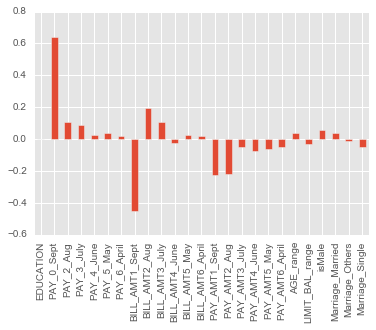

In [51]:
analysis(logit_coef_scaled, logit_acc_scaled, cc_data_Xs_names)

### Logitic Interpretation of Full Model

PAY_0_Sept and BILL_AMT1_Sept are the two strongest indicators of default. Pay_0_Sept and Bill_AMT1_Sept have high weights, >0.4 and <-0.4 respectively, compared to the other coefficients and are significant to the model. Secondarily, PAY_AMT1_Sept and PAY_AMT2_Aug have a similar strength of indicators. PAY_0_Sept indicates how many months late is the payment, so it is logical that as this increases the log odd off default would increase as well. BILL_AMT1 indicates the amount billed, and the weighting suggest counter to logic that bigger bills tended to default less frequently. Due to the high multicollinearity of the BILL_AMT variables, as discovered previously in project 1, this weighting might not be trustable.

### Reduced Logistic Model

In [65]:
logit_reduced_model = ['PAY_0_Sept',
                       'BILL_AMT1_Sept',
                       'PAY_AMT1_Sept',
                       'PAY_AMT2_Aug']

cc_data_Xs_logit_reduced = cc_data_processed[logit_reduced_model].values

# Column names for labeling
cc_data_Xs_names_lr = cc_data_processed[logit_reduced_model].columns

In [53]:
logit_coef_scaled_lr, logit_acc_scaled_lr = full_classify(cc_data_Xs_logit_reduced, cc_data_target,  cv_object, 
                                                          logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 0  ====
accuracy 0.808166666667
confusion matrix
 [[4519  143]
 [1008  330]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4662
          1       0.70      0.25      0.36      1338

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.607981620313
SCALED DATA

====Iteration 1  ====
accuracy 0.818833333333
confusion matrix
 [[4564  153]
 [ 934  349]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4717
          1       0.70      0.27      0.39      1283

avg / total       0.80      0.82      0.79      6000

ROC Score 
 0.61979141795


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 2  ====
accuracy 0.812666666667
confusion matrix
 [[4513  152]
 [ 972  363]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4665
          1       0.70      0.27      0.39      1335

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.61966352349
SCALED DATA

====Iteration 3  ====
accuracy 0.815333333333
confusion matrix
 [[4504  167]
 [ 941  388]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.96      0.89      4671
          1       0.70      0.29      0.41      1329

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.628098159094


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 4  ====
accuracy 0.807666666667
confusion matrix
 [[4498  155]
 [ 999  348]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4653
          1       0.69      0.26      0.38      1347

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.612520025637
SCALED DATA

====Iteration 5  ====
accuracy 0.804166666667
confusion matrix
 [[4466  152]
 [1023  359]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4618
          1       0.70      0.26      0.38      1382

avg / total       0.79      0.80      0.77      6000

ROC Score 
 0.61342688492


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 6  ====
accuracy 0.815333333333
confusion matrix
 [[4538  137]
 [ 971  354]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4675
          1       0.72      0.27      0.39      1325

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.618932499243
SCALED DATA

====Iteration 7  ====
accuracy 0.805166666667
confusion matrix
 [[4469  169]
 [1000  362]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.96      0.88      4638
          1       0.68      0.27      0.38      1362

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.614673744759


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 8  ====
accuracy 0.814833333333
confusion matrix
 [[4564  153]
 [ 958  325]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4717
          1       0.68      0.25      0.37      1283

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.610438339229
SCALED DATA

====Iteration 9  ====
accuracy 0.8145
confusion matrix
 [[4531  148]
 [ 965  356]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4679
          1       0.71      0.27      0.39      1321

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.61893105908
done. It took 1.306074857711792 seconds.


The average accuracy score is:  0.811666666667
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.814336040116
BILL_AMT1_Sept has weight of -0.123138449747
PAY_AMT1_Sept has weight of -0.22155154193
PAY_AMT2_Aug has weight of -0.278628551913


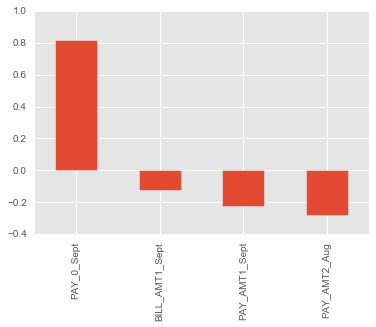

In [54]:
analysis(logit_coef_scaled_lr, logit_acc_scaled_lr, cc_data_Xs_names_lr)

### Comparison of Full Model to Reduced Model

The reduced model supports the analysis of the full model variable determined to be unecessary. The full model accuracy was 81.3% compared to the reduced model of 81.2%.

## Support Vector Machine - Using SGDClassifier

In [56]:
# Create New Cross Validation object
svg_cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=3, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=3, learning_rate='optimal', alpha=1)

# Parameteres to search on:
params = {'penalty':('l1','l2'),
          'fit_intercept':(True, False),
          'average':(True,False)}

# Run grid search with cv_object
sgd_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, svg_cv_object)

# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

The best estimator:  SGDClassifier(alpha=1, average=True, class_weight=None, epsilon=0.1, eta0=0.0,
       fit_intercept=False, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=3, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
The best accuracy score is:  0.778833333333
The best parameters of model is:  {'average': True, 'penalty': 'l2', 'fit_intercept': False}


In [61]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled, sgd_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, sgd_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.563
confusion matrix
 [[2468 2229]
 [ 393  910]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.65      4697
          1       0.29      0.70      0.41      1303

avg / total       0.74      0.56      0.60      6000

ROC Score 
 0.611915052978


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.574666666667
confusion matrix
 [[2518 2159]
 [ 393  930]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.54      0.66      4677
          1       0.30      0.70      0.42      1323

avg / total       0.74      0.57      0.61      6000

ROC Score 
 0.620663574388


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.564666666667
confusion matrix
 [[2469 2228]
 [ 384  919]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.53      0.65      4697
          1       0.29      0.71      0.41      1303

avg / total       0.74      0.56      0.60      6000

ROC Score 
 0.615475072592


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.564166666667
confusion matrix
 [[2518 2201]
 [ 414  867]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.66      4719
          1       0.28      0.68      0.40      1281

avg / total       0.74      0.56      0.60      6000

ROC Score 
 0.605201306394


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.569
confusion matrix
 [[2508 2156]
 [ 430  906]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.54      0.66      4664
          1       0.30      0.68      0.41      1336

avg / total       0.73      0.57      0.60      6000

ROC Score 
 0.607939780816


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.573666666667
confusion matrix
 [[2481 2167]
 [ 391  961]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.66      4648
          1       0.31      0.71      0.43      1352

avg / total       0.74      0.57      0.61      6000

ROC Score 
 0.622288392793


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.5725
confusion matrix
 [[2475 2178]
 [ 387  960]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.66      4653
          1       0.31      0.71      0.43      1347

avg / total       0.74      0.57      0.61      6000

ROC Score 
 0.622304885561


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.5675
confusion matrix
 [[2445 2181]
 [ 414  960]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.65      4626
          1       0.31      0.70      0.43      1374

avg / total       0.73      0.57      0.60      6000

ROC Score 
 0.613612163639


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.5655
confusion matrix
 [[2483 2189]
 [ 418  910]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.53      0.66      4672
          1       0.29      0.69      0.41      1328

avg / total       0.73      0.57      0.60      6000

ROC Score 
 0.608352502476


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.563833333333
confusion matrix
 [[2422 2208]
 [ 409  961]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.52      0.65      4630
          1       0.30      0.70      0.42      1370

avg / total       0.73      0.56      0.60      6000

ROC Score 
 0.612285002601
done. It took 8.6934974193573 seconds.


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The average accuracy score is:  0.56785
Coefficients and column names same length: True

EDUCATION has weight of -0.0288583023427
PAY_0_Sept has weight of 0.170504331998
PAY_2_Aug has weight of 0.12120932151
PAY_3_July has weight of 0.0961133033922
PAY_4_June has weight of 0.0769722063974
PAY_5_May has weight of 0.0678443542593
PAY_6_April has weight of 0.0628954924106
BILL_AMT1_Sept has weight of -0.0167746874564
BILL_AMT2_Aug has weight of -0.0118631124724
BILL_AMT3_July has weight of -0.0110464675658
BILL_AMT4_June has weight of -0.00874484310816
BILL_AMT5_May has weight of -0.006867910852
BILL_AMT6_April has weight of -0.00621748417397
PAY_AMT1_Sept has weight of -0.0324298929884
PAY_AMT2_Aug has weight of -0.0224115642598
PAY_AMT3_July has weight of -0.0201089659666
PAY_AMT4_June has weight of -0.0212356077089
PAY_AMT5_May has weight of -0.0213444443573
PAY_AMT6_April has weight of -0.0171661319803
AGE_range has weight of 0.010796966665
LIMIT_BAL_range has weight of -0.04259818008

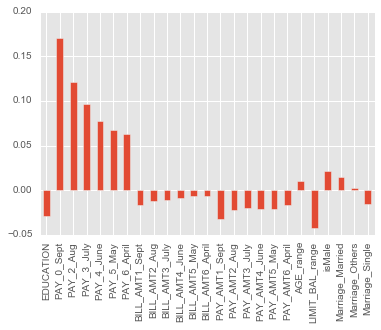

In [62]:
analysis(sgd_coef_scaled, sgd_acc_scaled, cc_data_Xs_names)

# SGD Reduced Model

In [70]:
svg_reduced_model = [ 'PAY_0_Sept', 'PAY_2_Aug', 'PAY_3_July', 'PAY_4_June',
       'PAY_5_May', 'PAY_6_April']

cc_data_Xs_svg_reduced = cc_data_processed[svg_reduced_model].values

# Column names for labeling
cc_data_Xs_names_sr = cc_data_processed[svg_reduced_model].columns

In [71]:
sgd_coef_scaled_sr, sgd_acc_scaled_sr = full_classify(cc_data_Xs_svg_reduced, cc_data_target, cv_object, 
                                                sgd_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 0  ====
accuracy 0.489333333333
confusion matrix
 [[1970 2672]
 [ 392  966]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.42      0.56      4642
          1       0.27      0.71      0.39      1358

avg / total       0.71      0.49      0.52      6000

ROC Score 
 0.567863123343
SCALED DATA

====Iteration 1  ====
accuracy 0.492
confusion matrix
 [[1985 2664]
 [ 384  967]]
Classification Report:
              precision    recall  f1-score   support

          0       0.84      0.43      0.57      4649
          1       0.27      0.72      0.39      1351

avg / total       0.71      0.49      0.53      6000

ROC Score 
 0.571369820942


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.498333333333
confusion matrix
 [[2012 2648]
 [ 362  978]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.43      0.57      4660
          1       0.27      0.73      0.39      1340

avg / total       0.72      0.50      0.53      6000

ROC Score 
 0.580805201461
SCALED DATA

====Iteration 3  ====
accuracy 0.491666666667
confusion matrix
 [[2023 2662]
 [ 388  927]]
Classification Report:
              precision    recall  f1-score   support

          0       0.84      0.43      0.57      4685
          1       0.26      0.70      0.38      1315

avg / total       0.71      0.49      0.53      6000



C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

ROC Score 
 0.568373297191
SCALED DATA

====Iteration 4  ====
accuracy 0.501
confusion matrix
 [[2067 2635]
 [ 359  939]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.44      0.58      4702
          1       0.26      0.72      0.39      1298

avg / total       0.72      0.50      0.54      6000

ROC Score 
 0.581510408645
SCALED DATA

====Iteration 5  ====
accuracy 0.493166666667


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

confusion matrix
 [[2022 2677]
 [ 364  937]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.43      0.57      4699
          1       0.26      0.72      0.38      1301

avg / total       0.72      0.49      0.53      6000

ROC Score 
 0.575259769565
SCALED DATA

====Iteration 6  ====
accuracy 0.496166666667
confusion matrix
 [[1991 2668]
 [ 355  986]]
Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.43      0.57      4659
          1       0.27      0.74      0.39      1341

avg / total       0.72      0.50      0.53      6000

ROC Score 
 0.58130855437
SCALED DATA

====Iteration 7  ====
accuracy 0.482333333333
confusion matrix
 [[1996 2714]
 [ 392  898]]


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

Classification Report:
              precision    recall  f1-score   support

          0       0.84      0.42      0.56      4710
          1       0.25      0.70      0.37      1290

avg / total       0.71      0.48      0.52      6000

ROC Score 
 0.559951612107
SCALED DATA

====Iteration 8  ====
accuracy 0.482666666667
confusion matrix
 [[1960 2695]
 [ 409  936]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.42      0.56      4655
          1       0.26      0.70      0.38      1345

avg / total       0.70      0.48      0.52      6000

ROC Score 
 0.558481706124
SCALED DATA

====Iteration 9  ====
accuracy 0.502833333333
confusion matrix
 [[2063 2643]
 [ 340  954]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.44      0.58      4706
          1       0.27      0.74      0.39      1294

avg / total       0.73      0.50      0.54      6000

ROC Score 
 0.5878126

The average accuracy score is:  0.49295
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.175724359501
PAY_2_Aug has weight of 0.12729580708
PAY_3_July has weight of 0.101076788877
PAY_4_June has weight of 0.0821105034771
PAY_5_May has weight of 0.0714005499733
PAY_6_April has weight of 0.0654172281654


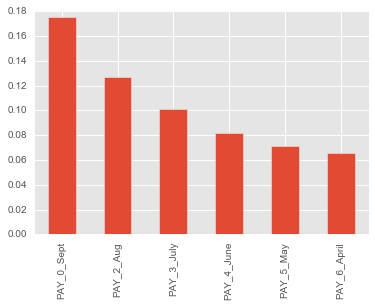

In [72]:
analysis(sgd_coef_scaled_sr, sgd_acc_scaled_sr, cc_data_Xs_names_sr)